# Clustering Hurricane Tracks: A Study of Different Methods

In this analysis, we explore and compare various clustering approaches for analyzing tropical cyclone tracks in the North Atlantic and West Pacific basins. Building upon the work in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al, we examine how different clustering algorithms perform when applied to hurricane track data represented through mass moments.

Group 3: Ahinoam Toubia, Dhruv Chakraborty, Martin Celedon, Xingyao Li

## Mass Moments and Track Representation

Hurricane tracks can be represented as open curves with associated properties (like wind speed) along their paths. Following Nakamura et al., we use mass moments to capture the essential characteristics of these tracks:

1. First moment (centroid): Represents the "center of mass" of the track
   - $M_1 = \frac{1}{\sum_{i=1}^n w(r_i)} \sum_{i=1}^n w(r_i)r_i$
   where $r_i$ are track coordinates and $w(r_i)$ are weights

2. Second moment (variance): Captures the shape and spread of the track
   - $M_2 = \frac{1}{\sum_{i=1}^n w(r_i)} \sum_{i=1}^n w(r_i)(r_i - M_1)^2$


## Clustering Methods

### K-means
- Groups tracks by minimizing within-cluster variance
- Assumes spherical clusters
- Use elbow method to determine optimal number of clusters
  - Plot sum of squared distances vs number of clusters (k)
  - Choose k where adding more clusters gives diminishing returns

### Gaussian Mixture Models (GMM)
- Allows for elliptical clusters with varying shapes/orientations
- Provides probabilistic cluster assignments
- Uses different covariance types:
  - Full: Each cluster has its own general covariance matrix
  - Tied: All clusters share the same covariance matrix
  - Diagonal: Each cluster has diagonal covariance matrix
  - Spherical: Each cluster has scalar covariance matrix

### Spectral Clustering 
- Uses eigenvalues of similarity matrix
- Can capture nonlinear relationships
- Transforms data into lower-dimensional space before clustering

## Evaluation Metrics

### Silhouette Score
- Measures cluster cohesion and separation
- Range: [-1, 1]; higher values indicate better clustering
- For each point i:
  - a(i) = average distance to points in same cluster
  - b(i) = average distance to points in nearest different cluster
  - s(i) = (b(i) - a(i)) / max(a(i), b(i))

### Bayesian Information Criterion (BIC)
- Used for model selection in GMM
- Penalizes model complexity
- BIC = ln(n)k - 2ln(L)
  - n = number of data points
  - k = number of parameters
  - L = maximum likelihood

### Log-likelihood
- Measures how well model fits data
- Higher values indicate better fit
- Useful for comparing different GMM variants

In [1]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy

In [2]:
import os
import requests
import xarray as xr # x-array

cwd=os.getcwd()
cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

File downloaded successfully.
<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...

In [3]:
# function definitions were moved to hurricane_utils.py for improving notebook readability
from hurricane_utils import * 

import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

### Replicating application of K-means for clustering tropical cyclones in the North Atlantic

In [4]:
atlantic_storms = get_tropical_cyclones(tks, basin='NA', start_year=1950)

# Calculate moments for valid storms only
moment_lst = [get_weighted_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if atlantic_storms[i] and get_weighted_moments(tks.sel(storm=i)) is not None]
moment_array = np.array(moment_lst)

moment_lst_plt = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if atlantic_storms[i] and get_moments(tks.sel(storm=i)) is not None]
moment_array_plt = np.array(moment_lst)


North Atlantic Basin Analysis:
------------------------------
Total storms in dataset: 2344
Storms in North Atlantic: 2338
Named storms/typhoons: 1716
Storms after 1950: 1195
Storms passing all filters: 905

Time period covered: 1950 - 2023
Average storms per year: 12.2


Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

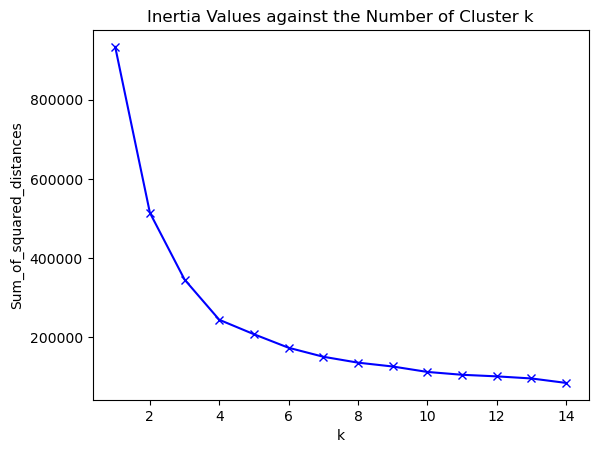

In [5]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'K-means clustering result, 6 clusters')

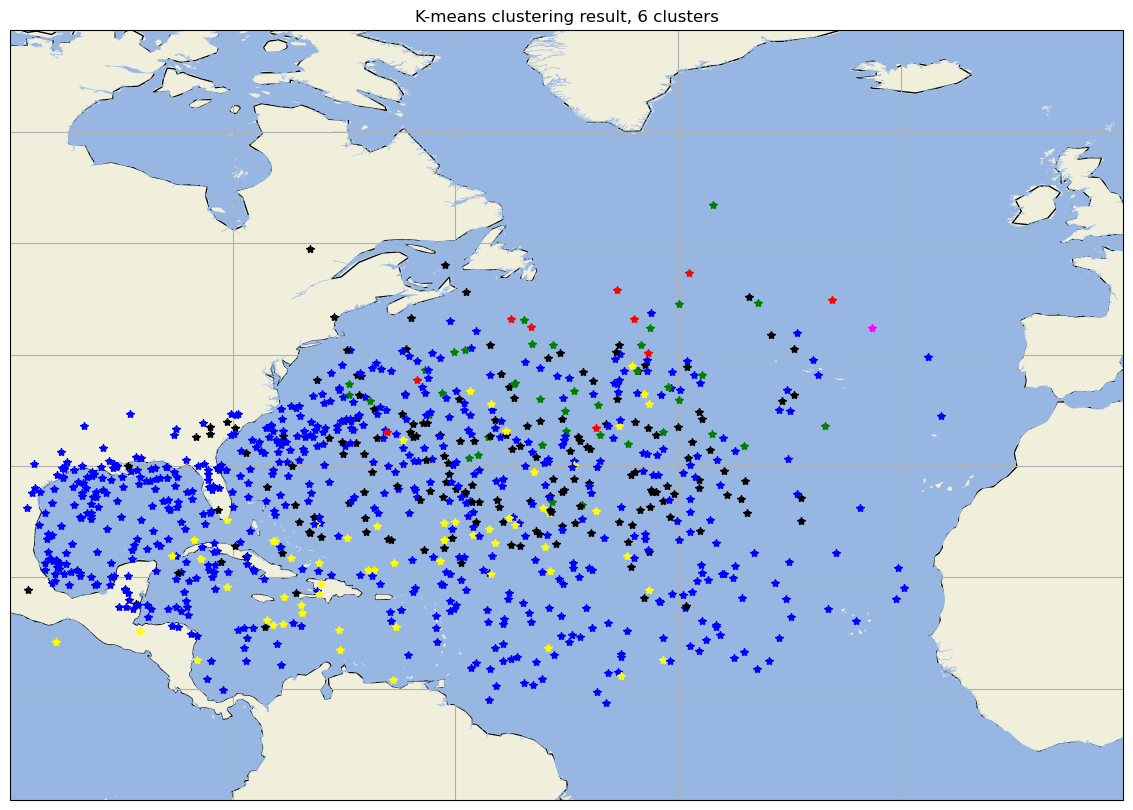

In [6]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst_plt)):
    ax.plot(moment_lst_plt[k][0], moment_lst_plt[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

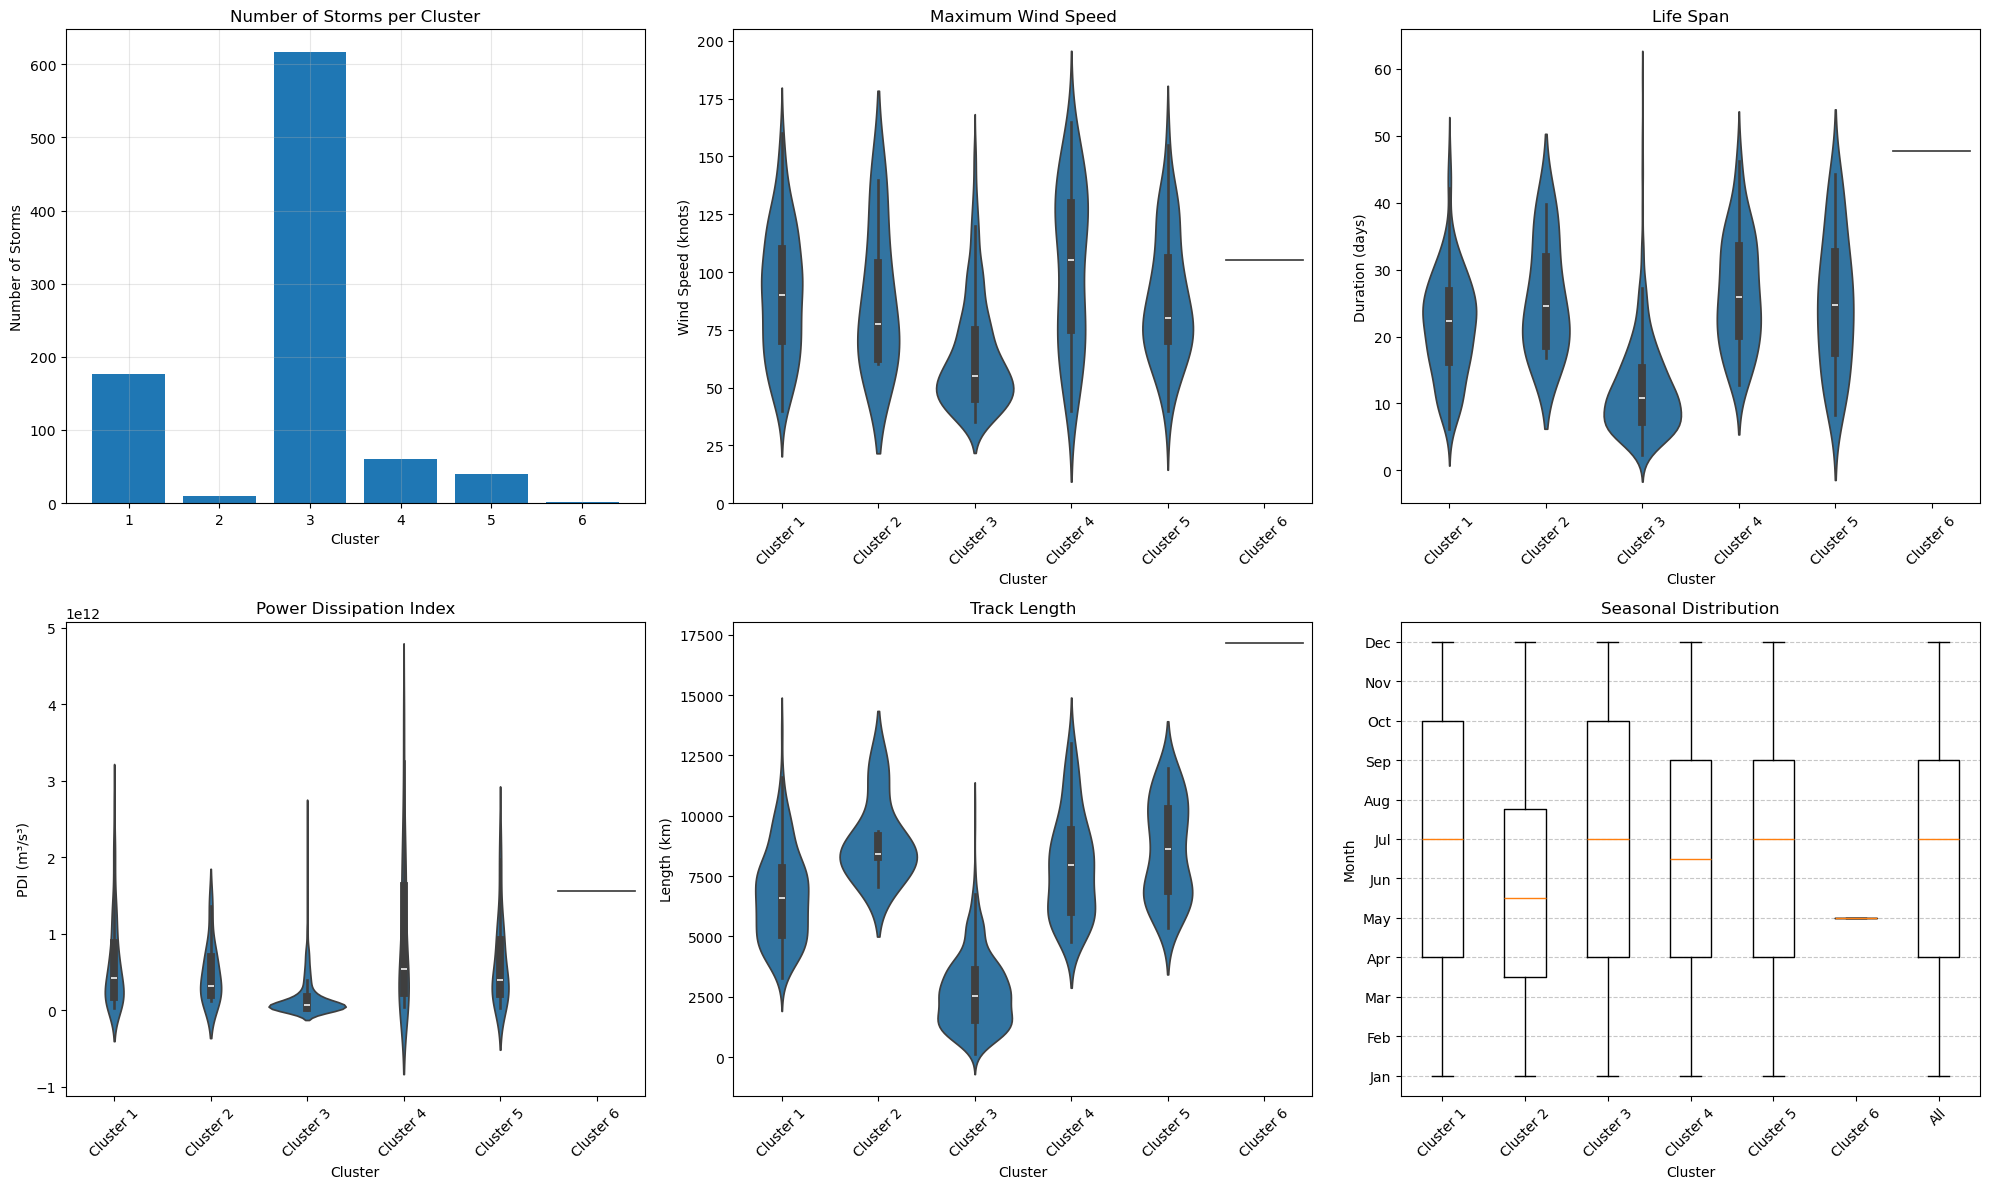

In [7]:
fig, stats = analyze_clusters(tks, labels, atlantic_storms)
plt.show()
# print(stats)

Text(0.5, 1.0, 'K-means clustering result, 12 clusters')

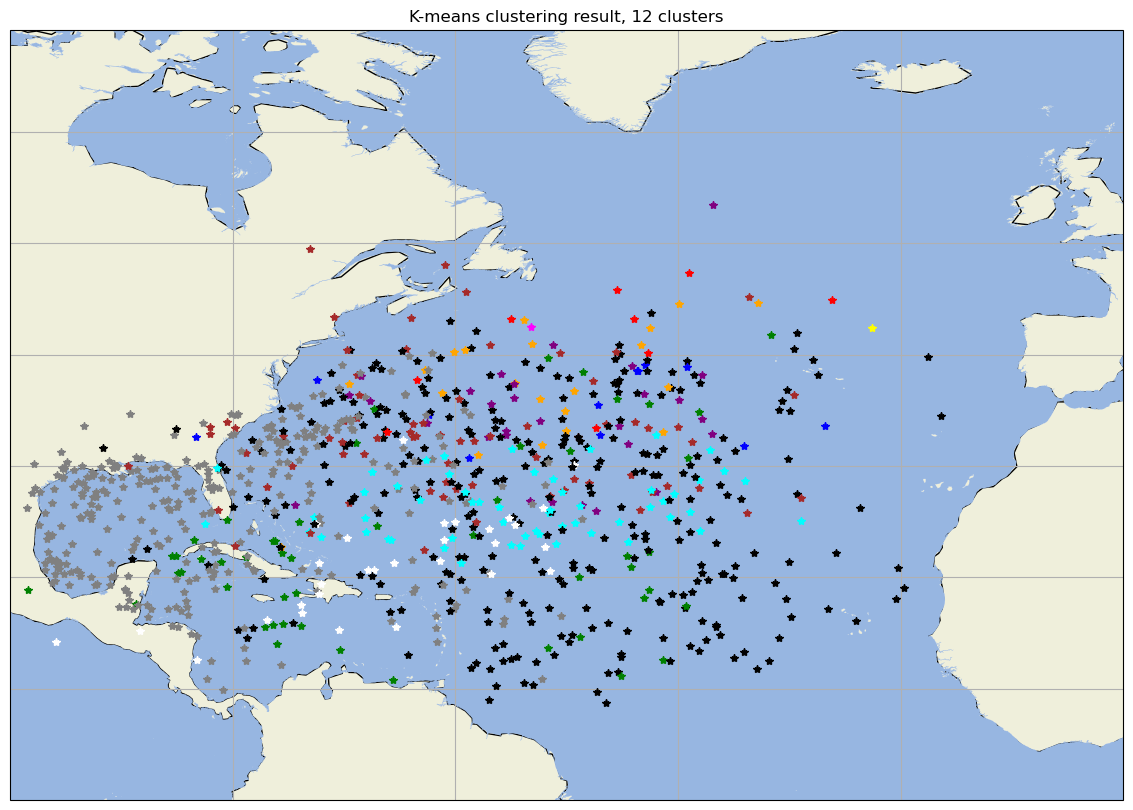

In [8]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst_plt)):
    ax.plot(moment_lst_plt[k][0], moment_lst_plt[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result, 12 clusters')

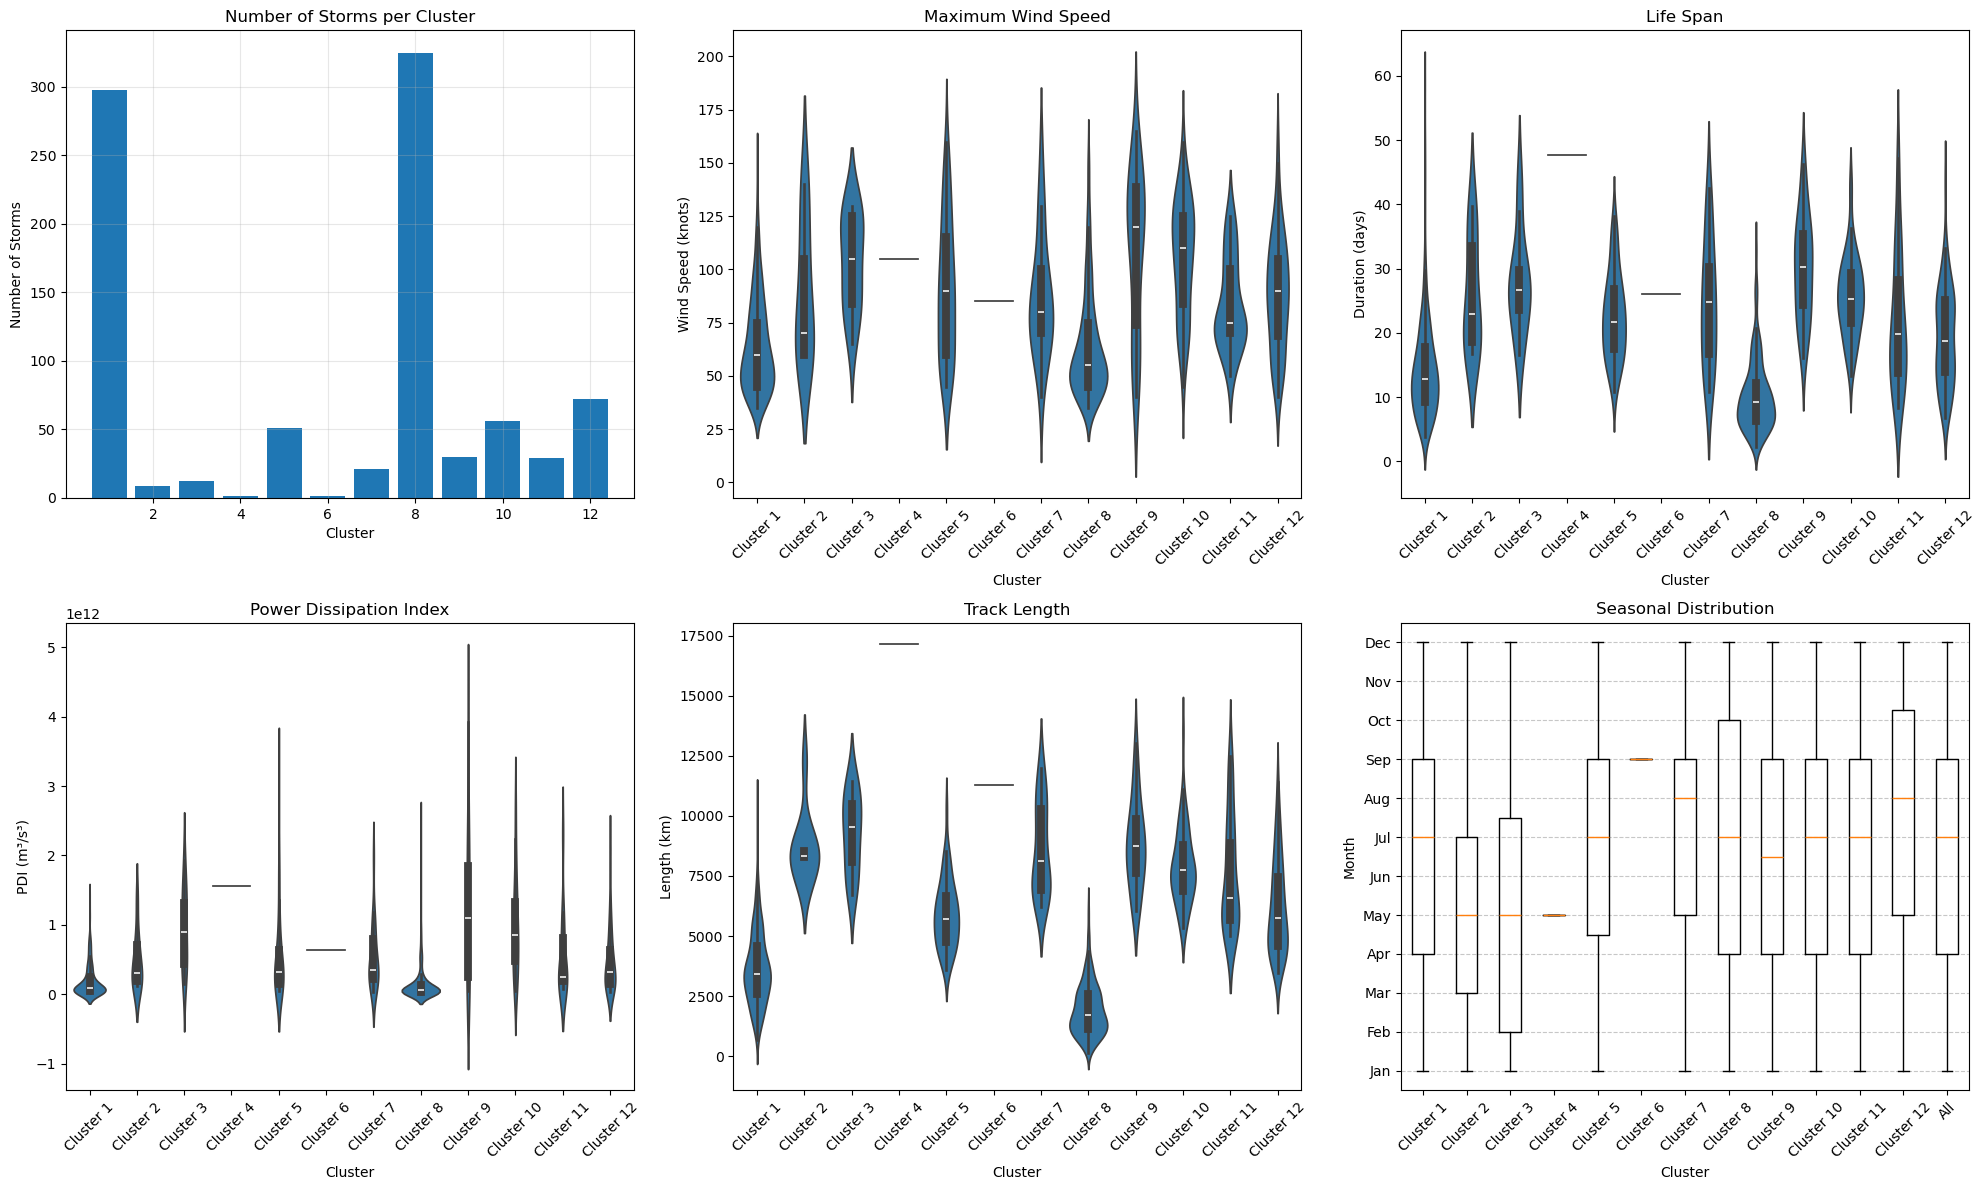

In [9]:
fig, stats = analyze_clusters(tks, labels, atlantic_storms)
plt.show()
# print(stats)

### Trying out other clustering strategies: Gaussian Mixture Models

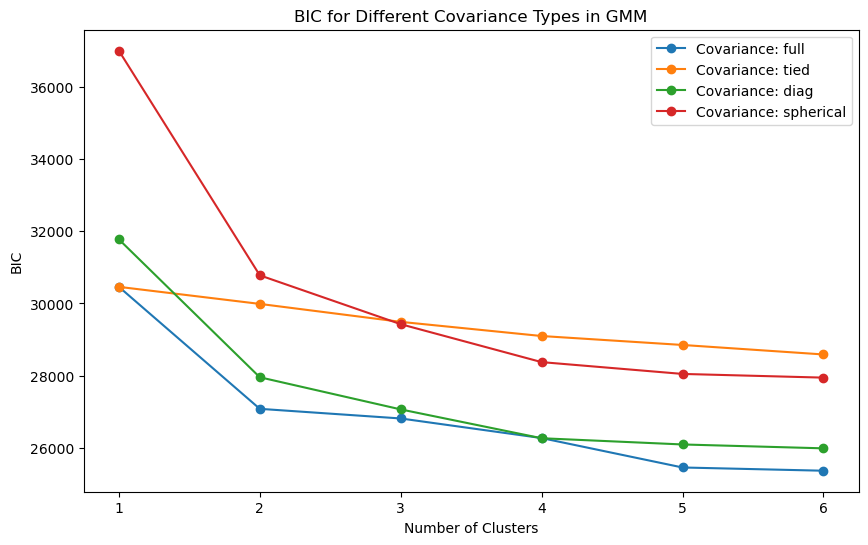

Optimal Covariance Type: full
Optimal Number of Clusters: 6


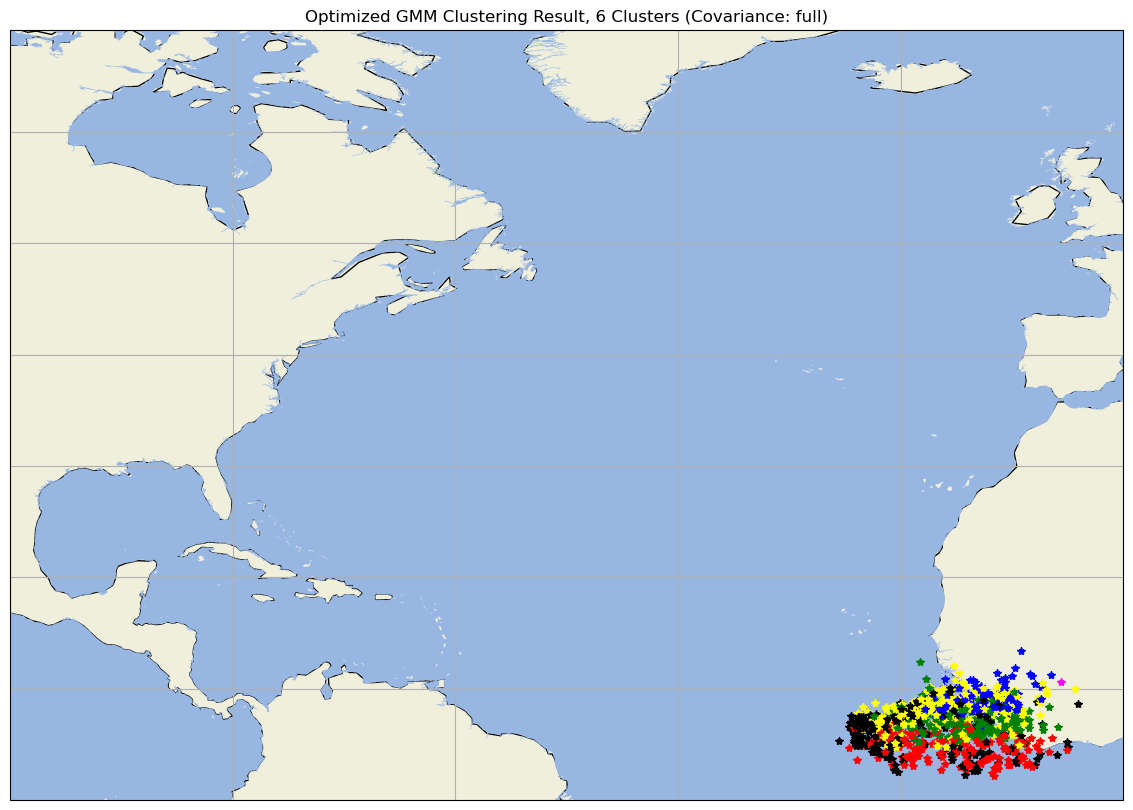

In [10]:
n_components_range = range(1, 7)
bic = []

# skipping normalization
# scaler = StandardScaler()
# moment_array_normalized = scaler.fit_transform(moment_array)

# Test different covariance types
covariance_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = {}

for cov_type in covariance_types:
    bic = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, 
                              covariance_type=cov_type, 
                              random_state=42)
        gmm.fit(moment_array)
        bic.append(gmm.bic(moment_array))
    bic_scores[cov_type] = bic

# Plot BIC scores for each covariance type
plt.figure(figsize=(10, 6))
for cov_type, bic in bic_scores.items():
    plt.plot(n_components_range, bic, marker='o', label=f'Covariance: {cov_type}')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Different Covariance Types in GMM')
plt.legend()
plt.show()

# Choose the best covariance type and number of clusters
optimal_covariance = min(bic_scores, key=lambda k: min(bic_scores[k]))
optimal_n = n_components_range[np.argmin(bic_scores[optimal_covariance])]
print(f"Optimal Covariance Type: {optimal_covariance}")
print(f"Optimal Number of Clusters: {optimal_n}")

# Fit the optimal GMM model
gmm = GaussianMixture(n_components=optimal_n, 
                      covariance_type=optimal_covariance, 
                      random_state=42)
gmm.fit(moment_array)
labels = gmm.predict(moment_array)

# Visualize GMM clustering results with consistent colors
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
ax = map_background()
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[labels[k]], marker='*')
plt.title(f'Optimized GMM Clustering Result, {optimal_n} Clusters (Covariance: {optimal_covariance})')
plt.show()

### Initial thoughts so far:

In our analysis, we set out to compare the performance of two popular clustering methods: Gaussian Mixture Model (GMM) and K-Means. Both were tasked with clustering storm tracks using their moments as input features. Initially, K-Means provided evenly distributed clusters, while GMM revealed an intriguing yet problematic pattern—clusters were stratified by latitude. This unexpected phenomenon hinted at GMM’s sensitivity to feature variances, particularly the dominance of latitude in shaping the cluster boundaries. While K-Means seemed immune to such effects, GMM’s results raised questions about its parameter settings and the role of data preprocessing.

To tackle this, we revisited the GMM setup. First, we standardized the data to reduce the impact of feature scale disparities. Next, we optimized the GMM parameters by exploring different covariance types and selecting the full covariance type based on the Bayesian Information Criterion (BIC). This adjustment allowed the GMM to better capture the underlying structure of the data. The resulting clusters no longer exhibited latitude-driven stratification and instead aligned more meaningfully with the spatial distribution of storm tracks. In the end, the refined GMM not only resolved its earlier limitations but also demonstrated clustering performance comparable to K-Means, highlighting the importance of careful parameter tuning and preprocessing when applying advanced clustering techniques.

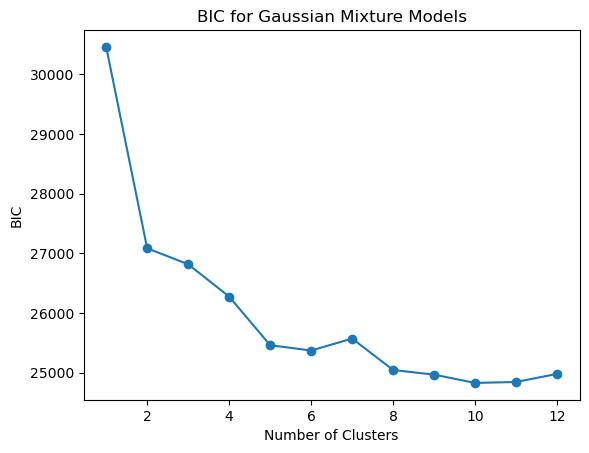

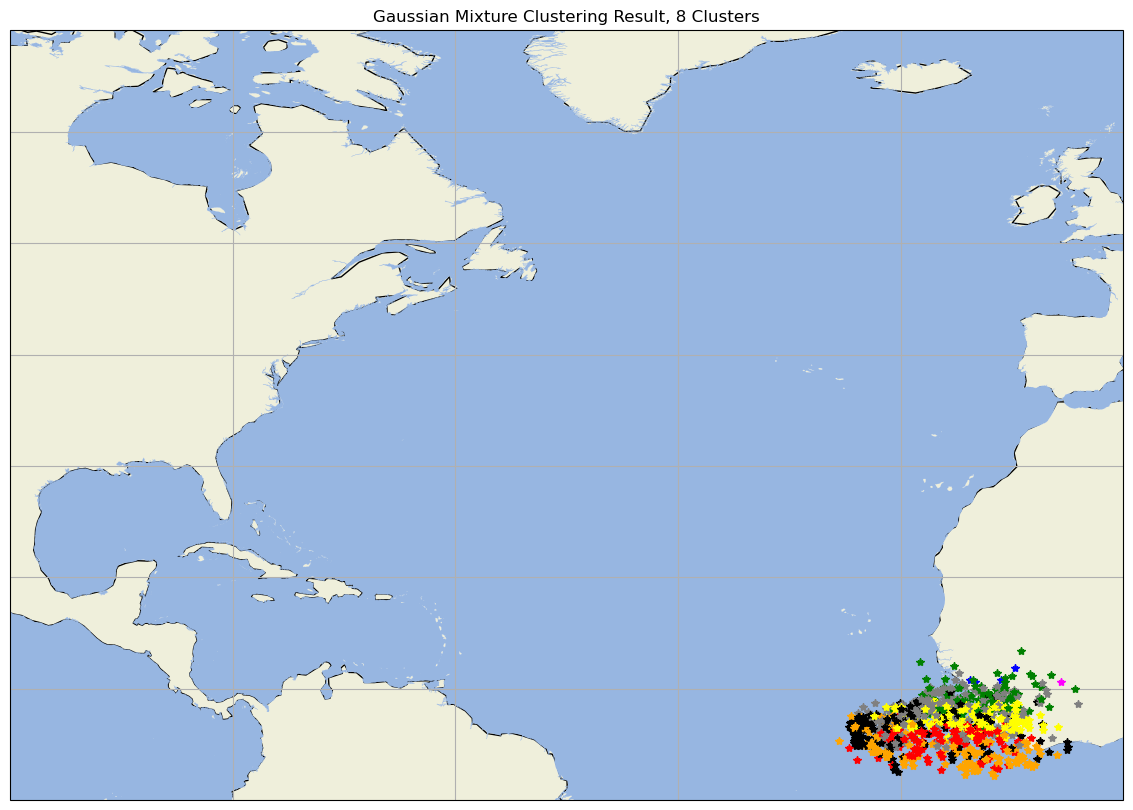

In [11]:
n_components_range = range(1, 13)
bic = []

# Calculate BIC to select the optimal number of clusters
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(moment_array)  
    bic.append(gmm.bic(moment_array))

plt.figure()
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Gaussian Mixture Models')
plt.show()

# Choose the optimal number of clusters and fit the model
# optimal_n = n_components_range[np.argmin(bic)]

# Choosing 8 since it looks like diminishing returns follow:
optimal_n = 8

gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(moment_array)
labels = gmm.predict(moment_array)

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[labels[k]], marker='*')
plt.title(f'Gaussian Mixture Clustering Result, {optimal_n} Clusters')
plt.show()

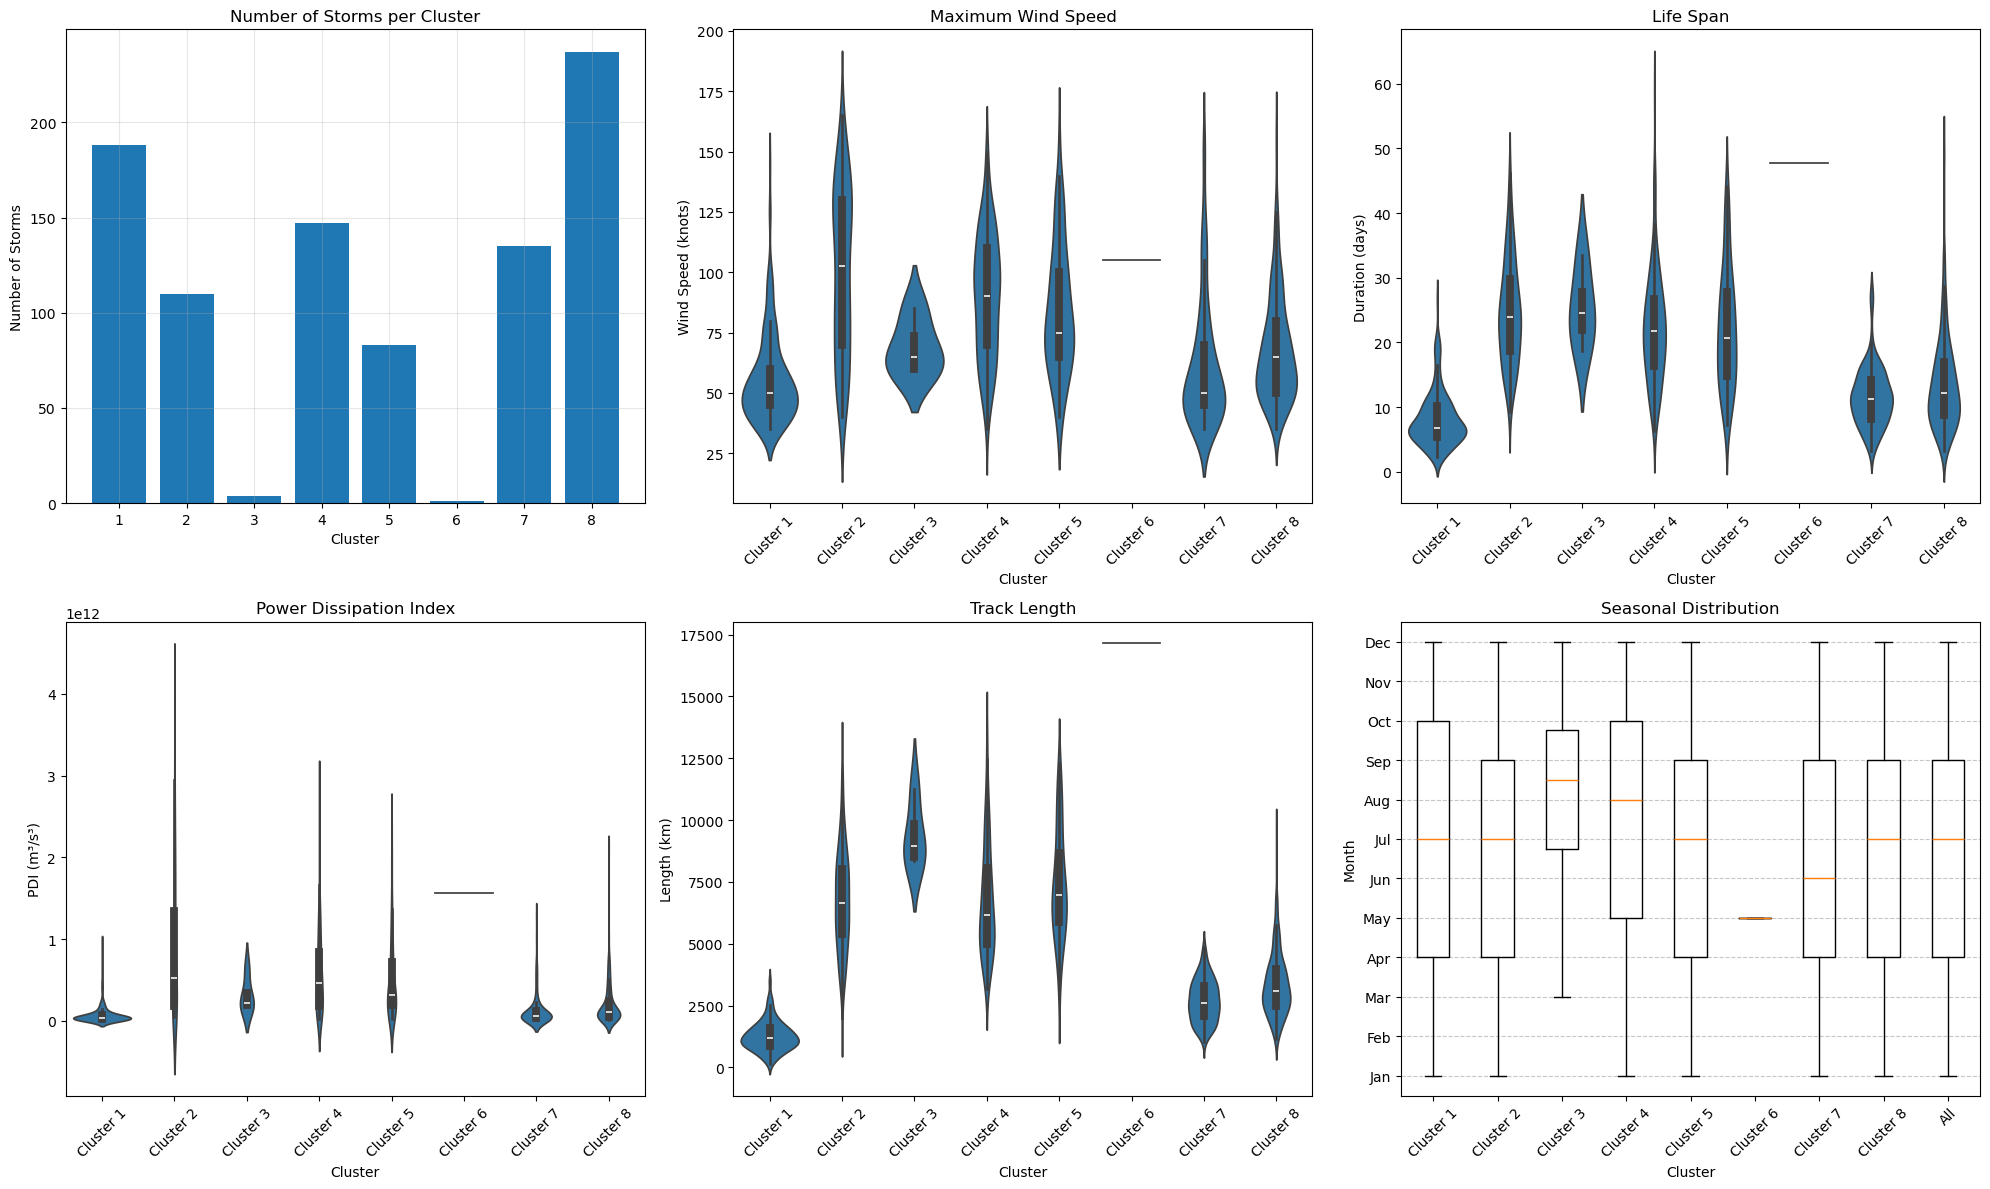

In [12]:
fig, stats = analyze_clusters(tks, labels, atlantic_storms)
plt.show()
# print(stats)

#### Comparing GMM with K means

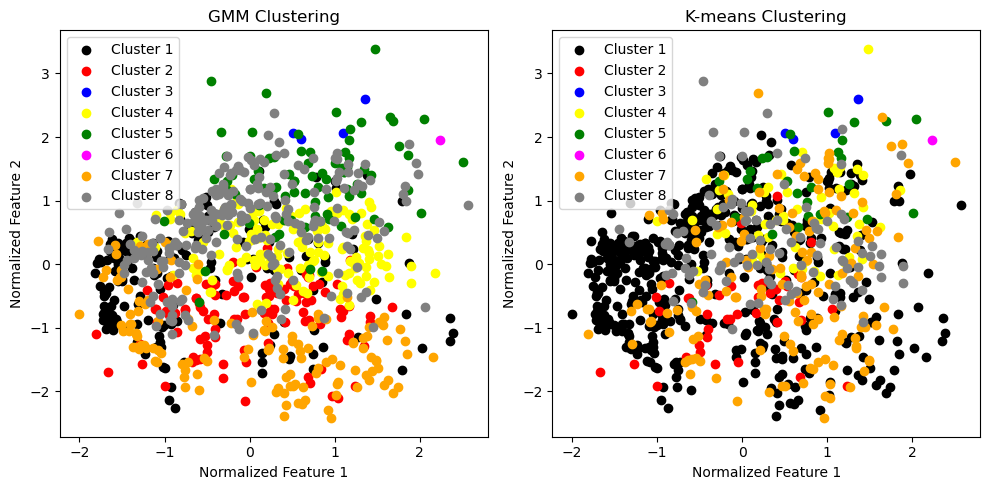

In [13]:
# Normalize the data to avoid plotting clustering results
scaler = StandardScaler()
moment_array_normalized = scaler.fit_transform(moment_array)

# Choose the optimal number of clusters
optimal_n = 8

gmm = GaussianMixture(n_components=optimal_n, random_state=42)
gmm_labels = gmm.fit_predict(moment_array)

# --- K-means Clustering ---
kmeans = KMeans(n_clusters=optimal_n, random_state=42)
kmeans_labels = kmeans.fit_predict(moment_array)

# --- Visual Comparison of Clustering Results ---
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']

plt.figure(figsize=(10, 5))

# GMM clustering result
plt.subplot(1, 2, 1)
for k in range(optimal_n):
    plt.scatter(moment_array_normalized[gmm_labels == k, 0],
                moment_array_normalized[gmm_labels == k, 1],
                color=colors[k], label=f'Cluster {k + 1}')
plt.title('GMM Clustering')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.legend()

# K-means clustering result
plt.subplot(1, 2, 2)
for k in range(optimal_n):
    plt.scatter(moment_array_normalized[kmeans_labels == k, 0],
                moment_array_normalized[kmeans_labels == k, 1],
                color=colors[k], label=f'Cluster {k + 1}')
plt.title('K-means Clustering')
plt.xlabel('Normalized Feature 1')
plt.ylabel('Normalized Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

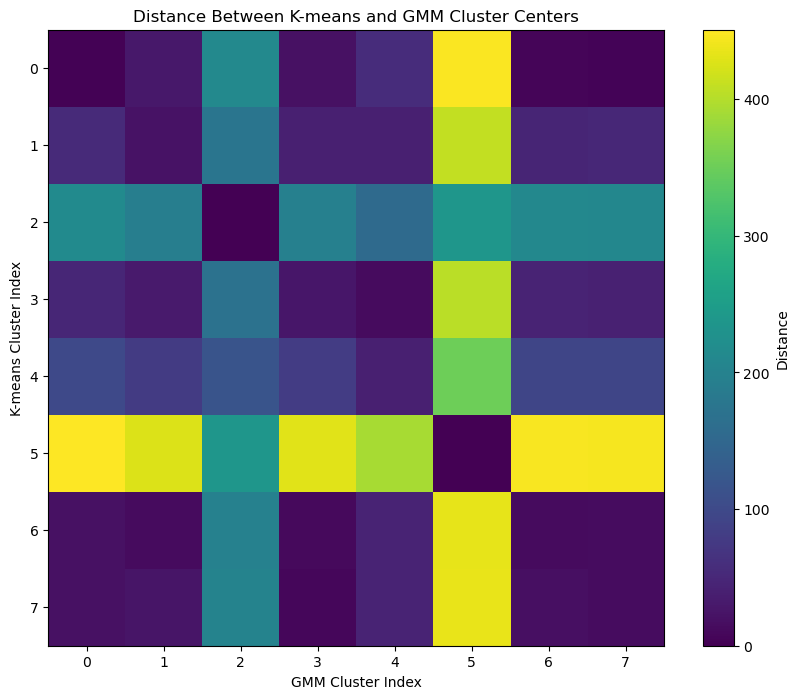

In [14]:
n_clusters = 8

# Fit K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(moment_array)
kmeans_centers = kmeans.cluster_centers_

# Fit GMM model
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(moment_array)
gmm_centers = gmm.means_

# Calculate distances between K-means and GMM centers
distances = np.linalg.norm(kmeans_centers[:, np.newaxis, :] - gmm_centers[np.newaxis, :, :], axis=2)

# Plot the distances as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(distances, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distance')
plt.title('Distance Between K-means and GMM Cluster Centers')
plt.xlabel('GMM Cluster Index')
plt.ylabel('K-means Cluster Index')
plt.xticks(range(n_clusters))
plt.yticks(range(n_clusters))
plt.show()

In [15]:
# Range of clusters to test
n_clusters_range = range(2, 13)
silhouette_kmeans = []
silhouette_gmm = []

# Calculate silhouette scores for each number of clusters
for n_clusters in n_clusters_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(moment_array)
    silhouette_kmeans.append(silhouette_score(moment_array, kmeans_labels))
    
    # GMM with full covariance
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(moment_array)
    silhouette_gmm.append(silhouette_score(moment_array, gmm_labels))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_kmeans, 'o-', label='KMeans')
plt.plot(n_clusters_range, silhouette_gmm, 's-', label='GMM (full)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal number of clusters for each method
print(f"Optimal clusters for KMeans: {n_clusters_range[np.argmax(silhouette_kmeans)]}")
print(f"Optimal clusters for GMM: {n_clusters_range[np.argmax(silhouette_gmm)]}")


KeyboardInterrupt: 

In [ ]:
# Calculate the total error for K-means (based on the distance from points to cluster centers)
def calculate_kmeans_log_likelihood(kmeans, data):
    # Total error for K-means (sum of squared distances from each point to its cluster center)
    distances = np.min(kmeans.transform(data), axis=1)
    return -np.sum(distances)

# Calculate the log-likelihood for GMM
def calculate_gmm_log_likelihood(gmm, data):
    return gmm.score(data) * len(data)  # Log-likelihood = sum of log-likelihoods for each sample

# Compare the log-likelihood of K-means and GMM models
def evaluate_models(moment_array, n_components_range):
    kmeans_log_likelihood = []
    gmm_log_likelihood = []

    for n_components in n_components_range:
        # K-means
        kmeans = KMeans(n_clusters=n_components, random_state=42)
        kmeans.fit(moment_array)
        kmeans_log_likelihood.append(calculate_kmeans_log_likelihood(kmeans, moment_array))

        # GMM
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
        gmm.fit(moment_array)
        gmm_log_likelihood.append(calculate_gmm_log_likelihood(gmm, moment_array))

    # Select the best model
    best_kmeans_index = np.argmax(kmeans_log_likelihood)  # K-means with the highest log-likelihood
    best_gmm_index = np.argmax(gmm_log_likelihood)  # GMM with the highest log-likelihood

    # Output the evaluation results for the best models
    print(f"Best K-means (log-likelihood): {best_kmeans_index + 1} clusters")
    print(f"K-means Log-Likelihood: {kmeans_log_likelihood[best_kmeans_index]}")
    
    print(f"Best GMM (log-likelihood): {best_gmm_index + 1} clusters")
    print(f"GMM Log-Likelihood: {gmm_log_likelihood[best_gmm_index]}")

    # Plot log-likelihood comparison
    plt.figure()
    plt.plot(n_components_range, kmeans_log_likelihood, label='K-means Log-Likelihood', marker='o')
    plt.plot(n_components_range, gmm_log_likelihood, label='GMM Log-Likelihood', marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.title('Log-Likelihood for K-means vs GMM')
    plt.show()

# Call the evaluation function
n_components_range = range(1, 13)
evaluate_models(moment_array, n_components_range)

### Spectral Clustering

Spectral clustering utilizes the eigenvalues of the similarity matrix of the data being clustered to convert the problem into a lower dimensional one. What, if any, physical interpretations might these eigenvalues have?

In [ ]:
# Try different numbers of clusters and affinity metrics
n_clusters_range = [4, 5, 6, 7, 8, 9, 10, 11, 12]  # Including original K=6 from paper
affinity_types = ['nearest_neighbors']
# tried 'rbf' affinity as well but this led to most cyclones being put in one of two clusters

results = {}

for affinity in affinity_types:
    print(f"\nTesting {affinity} affinity:")
    
    for n_clusters in n_clusters_range:
        # Fit Spectral Clustering
        spectral = SpectralClustering(n_clusters=n_clusters, 
                                    affinity=affinity,
                                    random_state=42)
        spectral_labels = spectral.fit_predict(moment_array)
        
        # Calculate silhouette score
        silhouette = silhouette_score(moment_array, spectral_labels)
        
        print(f"\nNumber of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette:.3f}")
        
        # Store results
        results[(affinity, n_clusters)] = {
            'labels': spectral_labels,
            'silhouette': silhouette
        }
        
        # Plot clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(moment_array_normalized[:, 0], 
                            moment_array_normalized[:, 1],
                            c=spectral_labels, 
                            cmap='tab10')
        plt.title(f'Spectral Clustering (n={n_clusters}, affinity={affinity})')
        plt.xlabel('Normalized Longitude Centroid')
        plt.ylabel('Normalized Latitude Centroid')
        plt.colorbar(scatter)
        plt.show()
        
        # Print cluster sizes
        print("\nCluster sizes:")
        for i in range(n_clusters):
            print(f"Cluster {i}: {np.sum(spectral_labels == i)} points")

# Plot silhouette scores comparison
plt.figure(figsize=(12, 6))
for affinity in affinity_types:
    scores = [results[(affinity, n)]['silhouette'] for n in n_clusters_range]
    plt.plot(n_clusters_range, scores, 'o-', label=affinity)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Spectral Clustering Performance')
plt.legend()
plt.grid(True)
plt.show()

# Compare best spectral result with K-means and GMM
best_affinity, best_n = max(results.items(), key=lambda x: x[1]['silhouette'])[0]
best_spectral_labels = results[(best_affinity, best_n)]['labels']

print("\nClustering Comparison:")
print(f"K-means Silhouette Score: {silhouette_score(moment_array, kmeans_labels):.3f}")
print(f"GMM Silhouette Score: {silhouette_score(moment_array, gmm_labels):.3f}")
print(f"Best Spectral Silhouette Score: {silhouette_score(moment_array, best_spectral_labels):.3f}")
print(f"(using {best_affinity} affinity and {best_n} clusters)")

# Plot best clustering results side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means
scatter = axes[0].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=kmeans_labels, 
                         cmap='tab10')
axes[0].set_title('K-means Clustering')
axes[0].set_xlabel('Normalized Longitude Centroid')
axes[0].set_ylabel('Normalized Latitude Centroid')

# GMM
scatter = axes[1].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=gmm_labels, 
                         cmap='tab10')
axes[1].set_title('GMM Clustering')
axes[1].set_xlabel('Normalized Longitude Centroid')

# Best Spectral
scatter = axes[2].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=best_spectral_labels, 
                         cmap='tab10')
axes[2].set_title(f'Spectral Clustering\n({best_affinity}, n={best_n})')
axes[2].set_xlabel('Normalized Longitude Centroid')

plt.tight_layout()
plt.show()

In [ ]:
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[best_spectral_labels[k]], marker='*')
plt.title(f'Spectral Clustering Result, {8} Clusters')
plt.show()

In [ ]:
fig, stats = analyze_clusters(tks, best_spectral_labels, atlantic_storms)
plt.show()
# print(stats)

In [ ]:
plot_cluster_trends(tks, best_spectral_labels, atlantic_storms)

#### DBSCAN

We tried the DBSCAN algorithm as well, but its results where underwhelming and it was difficult to for it to produce more than 2 clusters. Some hypothesese for why this may be the case:
- Mass moments (centroids/variances) likely spread uniformly in feature space without clear density contrasts. DBSCAN requires dense regions separated by sparse areas, which storm track data might lack.
- With 5 dimensions (2 for centroid, 3 for covariance), the distance metrics become less meaningful
- DBSCAN's eps parameter is hard to tune when the clusters have varying densities, which is the case with hurricane tracks

## Let's try out our methods for clustering cyclones in the West Pacific

In [ ]:
# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc'
output_file = 'data/WP_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc')

datatowrite = filedata.read()

with open('data/WP_data.nc', 'wb') as f:   
    f.write(datatowrite)

tks = xr.open_dataset('data/WP_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

In [ ]:
# Get West Pacific storms
wp_storms = get_tropical_cyclones(tks, basin='WP', start_year=1950)

# Calculate moments for valid storms only
wp_moment_lst = [get_weighted_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
                 if wp_storms[i] and get_weighted_moments(tks.sel(storm=i)) is not None]
wp_moment_array = np.array(wp_moment_lst)

In [ ]:
# Arrays to store scores
sum_of_squares = []
silhouette_scores = []
K = range(2, 15)  # Note: silhouette requires at least 2 clusters

# Calculate both metrics for each k
for k in K:
    # Fit k-means and get inertia (sum of squared distances)
    km = k_means(wp_moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
    
    # Calculate silhouette score
    labels = km[1]
    silhouette_avg = silhouette_score(wp_moment_array, labels)
    silhouette_scores.append(silhouette_avg)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K, sum_of_squares, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of squared distances')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette plot
ax2.plot(K, silhouette_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print optimal k based on silhouette score
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Maximum silhouette score: {max(silhouette_scores):.3f}")

In [ ]:
km = k_means(wp_moment_lst, n_clusters=8)
labels = km[1]

# Plot clustering results
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
ax = map_background(extent=[100, 180, 0, 60])  # Adjusted extent for West Pacific
for k in range(len(wp_moment_lst)):
    ax.plot(wp_moment_lst[k][0], wp_moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means Clustering Result - West Pacific Basin (8 clusters)')
plt.show()

# Analyze cluster characteristics
fig, stats = analyze_clusters(tks, labels, wp_storms)
plt.show()

In [ ]:
# Test different covariance types and components
n_components_range = range(1, 15)
covariance_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = {}

# Calculate BIC for each combination
for cov_type in covariance_types:
    bic = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, 
                             covariance_type=cov_type, 
                             random_state=42)
        gmm.fit(wp_moment_array)
        bic.append(gmm.bic(wp_moment_array))
    bic_scores[cov_type] = bic

# Plot BIC scores for each covariance type
plt.figure(figsize=(12, 6))
for cov_type, bic in bic_scores.items():
    plt.plot(n_components_range, bic, marker='o', label=f'Covariance: {cov_type}')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs Number of Components for Different Covariance Types')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal configuration
optimal_bic = float('inf')
optimal_components = 0
optimal_covariance = ''

for cov_type, bic in bic_scores.items():
    min_bic = min(bic)
    if min_bic < optimal_bic:
        optimal_bic = min_bic
        optimal_components = n_components_range[np.argmin(bic)]
        optimal_covariance = cov_type

print(f"Optimal configuration:")
print(f"Number of components: {optimal_components}")
print(f"Covariance type: {optimal_covariance}")

# Fit optimal GMM model and visualize results
optimal_gmm = GaussianMixture(n_components=optimal_components,
                             covariance_type=optimal_covariance,
                             random_state=42)
optimal_gmm.fit(wp_moment_array)
labels = optimal_gmm.predict(wp_moment_array)

# Plot clustering results
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background(extent=[100, 180, 0, 60])  # Adjusted for West Pacific
for k in range(len(wp_moment_array)):
    ax.plot(wp_moment_array[k][0], wp_moment_array[k][1], 
            c=colors[labels[k]], marker='*')
plt.title(f'GMM Clustering Result - West Pacific Basin\n' + 
          f'({optimal_components} components, {optimal_covariance} covariance)')
plt.show()

# Analyze cluster characteristics
fig, stats = analyze_clusters(tks, labels, wp_storms)
plt.show()

In [ ]:
# Standardize the features for plots
scaler = StandardScaler()
wp_moment_array_normalized = scaler.fit_transform(wp_moment_array)

# Test range of clusters
n_clusters_range = range(2, 13)
silhouette_scores = []

# Calculate silhouette scores for nearest_neighbors affinity
for n_clusters in n_clusters_range:
    spectral = SpectralClustering(n_clusters=n_clusters,
                                 affinity='nearest_neighbors',
                                 random_state=42)
    labels = spectral.fit_predict(wp_moment_array)
    score = silhouette_score(wp_moment_array, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Spectral Clustering Performance')
plt.grid(True)
plt.show()

# Get optimal number of clusters
optimal_n = n_clusters_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_n}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

In [ ]:
# Fit spectral clustering with optimal parameters
spectral = SpectralClustering(n_clusters=6,
                             affinity='nearest_neighbors',
                             random_state=42)
labels = spectral.fit_predict(wp_moment_array)

# Plot clustering results
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background(extent=[100, 180, 0, 60])  # Adjusted for West Pacific
for k in range(len(wp_moment_array)):
    ax.plot(wp_moment_array[k][0], wp_moment_array[k][1], 
            c=colors[labels[k]], marker='*')
plt.title(f'Spectral Clustering Result - West Pacific Basin (6 clusters)')
plt.show()

# Analyze cluster characteristics
fig, stats = analyze_clusters(tks, labels, wp_storms)
plt.show()

In [ ]:
# Use the previous clustering results
plot_cluster_trends(tks, labels, wp_storms)